# Part 1, Re-track IBB Index

If you have read the paper, you may notice that the first part of application in the paper is to select a subset of stocks from IBB Index to re-track the Index.


OK, let's start.

In [11]:
# Run some setup code for this notebook.
# %matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [12]:
## Save future files to your drive
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# %cd "/content/drive/My Drive/FirmAI/FinML/Data/Deep Portfolio"

In [13]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('input/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('input/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('input/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('input/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [14]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder on weekly stock price changes
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('output/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0824  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9195 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8487 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8043 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7694  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7396 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7110 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6831 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6549 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6272 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6003 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5752 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5513 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5284 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [15]:
# # Train autoencoder and capture the training history
# history = autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size=10)

# # Plot the loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss Function Value vs Epochs')
# plt.legend()
# plt.grid(True)
# plt.show()

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [16]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.2987617254257202 TLGT    US Equity
65 1.341023564338684 INO     US Equity
38 1.5708024501800537 LXRX    US Equity
76 1.834132194519043 NVAX    US Equity
66 2.072211265563965 CERS    US Equity
79 2.2136752605438232 ZGNX    US Equity
81 2.4037973880767822 MNOV    US Equity
77 2.430232286453247 PDLI    US Equity
71 2.489384412765503 CRIS    US Equity
52 2.767688274383545 IMMU    US Equity
17 2.837184190750122 EXEL    US Equity
49 3.1011078357696533 DEPO    US Equity
75 3.1144497394561768 GERN    US Equity
37 3.3898096084594727 ARRY    US Equity
67 3.6751091480255127 PACB    US Equity
73 3.689378499984741 AVDL    US Equity
48 3.876844882965088 SGYP    US Equity
19 4.013592720031738 OPK     US Equity
42 4.1595916748046875 RGEN    US Equity
31 4.19942045211792 HZNP    US Equity
72 4.232657432556152 PRTK    US Equity
55 4.267542362213135 BCRX    US Equity
82 4.340072154998779 ARWR    US Equity
80 4.563180923461914 CGEN    US Equity
69 4.880807399749756 RIGL   

Let's have a look on how well this auto-encoder works on a certain stock.

<Axes: >

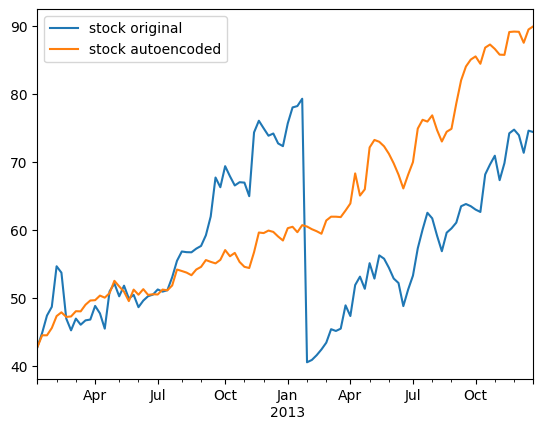

In [17]:
which_stock = 1

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

# Phase 2: Calibrating

In [18]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('output/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.7086
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0366 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6344 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3692 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1749 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0087 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8358 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6060 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4532 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3430 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2522 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1731 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1024 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0377 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/500


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\902410618.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0939  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8977 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9953 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5938 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3394 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1558  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0189 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9075 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8147 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7342 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6702 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6166  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5787 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5422 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5154

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\902410618.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8677  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1777 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5344 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2872 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1036 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9687  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8765  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8133  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7540  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7080 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6640  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5919  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5452  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4943  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\902410618.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())


Now we would like to see how similar these 3 portfolios perform as the original IBB Index does on training dates.

S25 2-norm difference:  62.097263
S45 2-norm difference:  5.1907163
S65 2-norm difference:  6.0840225


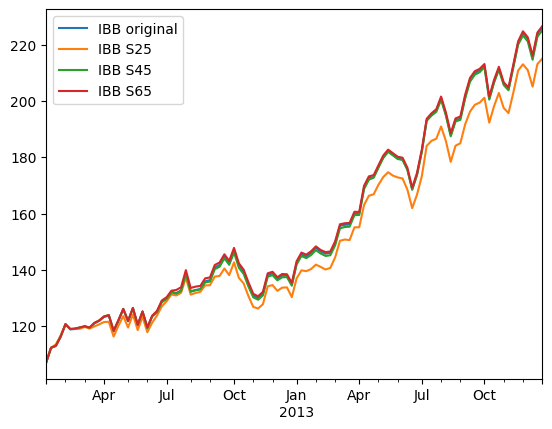

In [21]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    


# Phase 3: Validating

In [22]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('output/retrack_s' + str(s) + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\302269489.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\302269489.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\302269489.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

S25 2-norm difference:  2097.289
S45 2-norm difference:  529.76764
S65 2-norm difference:  260.6806


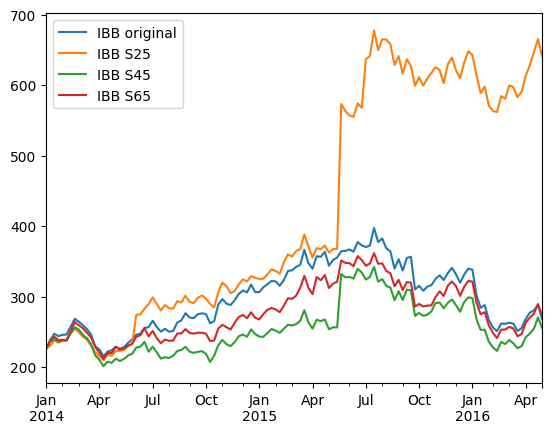

In [24]:
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].to_numpy(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

# Phase 4: Verifying

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 

From my perspective, Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. It just reflects the trade-off between more stocks in the portfolios and higher MSE.

In [25]:
error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2213  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6971 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5625 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8740 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4607  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2196 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0596 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9490 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8657 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7970  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7389 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6893 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6458 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6050 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11.3382
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4612  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9220  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7482 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0160  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5765 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2909 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0652  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8973  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7642  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6538  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5684  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4983 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4452  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.6944
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3992  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7903  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4491  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2202  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0521  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9402  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8563  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7920  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7388  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6930  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6534  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6202  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5908  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.3319
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4219  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9613  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1678  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7112  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4601  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3071  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2013  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1302  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0762  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0342 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0009  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9752  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9528  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.9968
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8011  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1286 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2961  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7717  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4054  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1594  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9605  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8180  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7040  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6118  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5360  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4709  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4131  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.5479
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8699  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4459  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0823  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7218  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4095  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1604  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9900  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8625  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7513  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6592 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5872  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5236  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4619  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5284  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9048  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0298  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6026  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2752 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0511 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8818  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7477 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6380 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5473 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4686 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3781 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2535  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1616  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5814
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0115  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4970 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7806  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4626 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2827  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1622 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0752  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9973 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9399 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8894  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8472  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8142 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7878  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9185  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7391
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7884  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2474 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8784 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6256 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4402  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2942  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1788 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0933 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0267  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9738 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9298 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8911 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7531  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1871 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6536 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4174  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2649  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1558 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0677 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9956 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9424 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8967 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8579 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8283 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8024 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7790 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6247
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7315  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1005  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6660  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3365  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1346  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0026 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9101 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8391  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7828 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7385 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7020 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6710 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6447 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9871  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1365  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5135 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2285  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0648 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9560 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8784 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8194 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7725  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7350  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7020  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6701 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6461 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6266  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2791 
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7277  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6220  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0740  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7038  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4860 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3307 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2130 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1134 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0346 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9624 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9060  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8417  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7925 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2086  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2997 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8845 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1490 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7683 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5034 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3010 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1462 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0239 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9109 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8244 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7589 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7049  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6600 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6224 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1944  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0862  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7230 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0149 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6275 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3752  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1950  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0636  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9657  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8895  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8304  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7834  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7450  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7130 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6199  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2338  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4128  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7834  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3970  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1853 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0528  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9600  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8887  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8315  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7778  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7342  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6961 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6639  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3565  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8453 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6676 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2721 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0854 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9670 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8849 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8222 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7722 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7303 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6943 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6611 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6310 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6038 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5840 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0443  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6778 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3265 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7717 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4874 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3036 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1721 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0802  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0040 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9403 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8851 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8405 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8031 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7727 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7461 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.1948  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7419  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7684  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4316 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2255  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0800 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9783 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9024 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8410 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7933 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7514 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7156 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6839 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6539 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.629

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6905  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7595 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0786 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5236  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2999 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1330 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0104  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9242 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8544  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7980 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7513  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7120  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6776 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6461 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1834
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1109  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4743 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1155  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8529  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6620 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5258  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4256  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3481  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2849  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2276  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1682  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0910 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9905  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.4324  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8883  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7514 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2246 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9621  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8098 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7085  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6455  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5987  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5655  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5396  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5162  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4987  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4831 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.7861
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8384
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8273  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4585  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2604  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1287  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0332 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9560 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8854
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7908
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7173  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6600  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6110  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5714  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8532  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0821 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1412 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8570 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7294 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6482 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5916 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5482 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5152 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4875 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4649 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4449 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4277 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4124 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3980 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.4142
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9708  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2883 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0918 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9314 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8150 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7285 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6646 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6138 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5716 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5367 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5083 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4850 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4650 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7617  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0836 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5585 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1338 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6260 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9983 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5215 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2857  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1406 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0339 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9473 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8719 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8084 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7534 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2138  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0907 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7359 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2135 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9658 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8266 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7380 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6729 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6219 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5804 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5468 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5185 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4944 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4738 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4561 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0058  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6526 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9203 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6550 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4759 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3464 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2326 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0415 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9234 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8432 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7847 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7402 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7052 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6535 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3769  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6692  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9510 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6140 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3645 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1810 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0492 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9503 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8737 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8115 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7587 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7151 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6767 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6433  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6158

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.1183  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8384 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5892 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2649 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0715 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9044 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7933 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7152 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6573 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6129 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5765 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5460 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5198 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4969 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4767 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4631  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3585  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1665 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3520 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8103 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5047 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3155 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1744 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0623  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9720  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8983 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8366  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7839 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7378  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3271  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2939 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5735 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2623 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0372 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9090 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8206  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7548 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7020 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6582 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6202  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5853 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5556  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5320 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.508

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1938  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5197 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1452 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8048 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3354  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8874 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5783 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3709 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2264 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1124 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0168 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9385 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8745 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8203 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7728 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8009  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1860 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6483 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1890 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6872 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2054 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9498 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8181 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7318 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6668 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6196 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5742 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5425 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5118 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4904 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4491  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3057 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4995 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0860 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8402 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6734 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5504 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4361 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3140 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2124  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1301 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0541 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9559 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8614 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7523 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.2527  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9540 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2747 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6733 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3253 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0571 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8768 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7534 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6623 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5947 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5428 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5023 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4701 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4441 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4227 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0662
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8717  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9429 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4992  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1925 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9975  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8685 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7772  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7081  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6524 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6067 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5697 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5382 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5104  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.48

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0810  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2603 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4503
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1260  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9217 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7825 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6056 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5477 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5016 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4654 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4359 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4117 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3919 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3745 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6152  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6068 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8546 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4327  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1543 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9247 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7302 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6312 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5658 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5160 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4761 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4439 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4165 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3929 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3726 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0122  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5182 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2201 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6941 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4657 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2327 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0632 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9343 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8261 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7433 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6227 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5766 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5377 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5046 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7128  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6615 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9814 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6719 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4478  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2709 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0812 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7781  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3921 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0520 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8415  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7160 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6316 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5690 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.515

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0604  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0536  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3362 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0049 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8147 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6992 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6216 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5663 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5242 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4911 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4618 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4370 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4155 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3976 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3803 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1457  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0608 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7892 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1718 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9090  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7583 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6544 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5820 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5278 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4866 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4487 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4184 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3953 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3739 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3547 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.4648  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5253 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0716 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4587 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1275 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9315 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7989  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7027 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6322 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5776  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5341 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4987  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4692 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4440 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.422

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9451  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0022
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8953  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2737 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0058 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8540 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7521 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6759 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6167 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5671 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5262 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4939 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4644  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4395 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4187

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8970  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0965 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3264 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6880 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2248 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9899 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8452 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7443 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6038 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5503 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5045 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4657 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4363 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8386  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5888 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5675 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2039 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0080 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8562  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7370 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6446 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5698 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5107 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4609 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4221 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3897 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3629 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3401 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0024  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7927 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5212 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9618 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1943 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5671 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2407 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0424 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9024 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7934 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7108 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6425 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5883 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5439 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0676  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5166 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0765 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8731 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7239 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6151 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5353 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4756  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4306  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3921  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3649  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3433 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3246 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3098  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4035  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0559 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8106 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4398 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2621 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1203 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9219 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7911 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6946 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6219 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5661 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5217 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4866 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4578 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4338 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0578  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6738 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7152 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2209 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9546 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7827 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6661 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5797 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5152 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4632 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4214 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3881  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3622 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3392 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3202 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0427  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8200 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1575 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8953 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7451  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6428 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5684  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5137 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4723  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4358  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4066  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3827 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3636 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3475  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6098  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1254 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4135 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1257 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9484  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8263 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7358 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6578  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5913 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5368 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4921 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4558 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4252 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3992 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3768

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8301  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6183 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5843 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1640 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9347 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7913 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6899 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6131 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5514 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4994 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4579 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4232 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3938 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3700 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3492 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2688  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3114 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5611 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1356 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7954  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5746 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3797 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1515 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8309 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4705  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1996 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0240 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8971 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7938 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7029

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8908
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7819  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2333  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9671 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8093 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7015 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6225 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5634  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5158 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4751 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4423 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4142 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3919 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3725 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.1435  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0850 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3899 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9830 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7356 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5896 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4925 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4269 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3784 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3409 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3126 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2883 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2517 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2388 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7773  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0594  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3757 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0611 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8643 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7277 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6266 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5488  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4880 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4410 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4010 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3689 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3441 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3233 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1090  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9755  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8555 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4228 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1765 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9979 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8615 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7522 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6378 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5599 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5022  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4574 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4210 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3910 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3661

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1344  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4660 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1550 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9474 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8091 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7069 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6293  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5713 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5217 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4831 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4487 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4219 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3964  
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3751 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8631
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0018
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1266  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6679 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3640 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1328 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9713 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8684 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7964  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6552 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5675 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5087  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4665 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4347 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9622  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6313 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7370  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3909 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1151 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9313 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7992 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7004  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6202 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5560 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5057 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4637 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4296 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4002 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3740

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3645  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8231  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1937 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9158 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7508 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6350 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5501 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4862 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4391 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4040 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3744 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3510 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3328 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3157 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2997 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0864  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5019 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1976  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6572 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3706 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0982 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9201 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7971 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7054 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6367 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5823 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5375 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5004 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4701 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4434 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0613
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6060  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0834 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9314 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8050 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7158 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6484 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5981 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5534 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5162 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4834 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4556 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4318 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4093 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3875 
E

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8170  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2264  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6890 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3728 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1294 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8804 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5482 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1895 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9354 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7771 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6597 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5661 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4972 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4478
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4063 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8696  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6293  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2341 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0184 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8652 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7498 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6659 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5933 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5348 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4879 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4443 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4080 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3787 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3539 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3299 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6907   
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4802 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7381 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2435 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0172 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8389 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7139 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6245 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5554 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5018 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4583 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4250 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3966 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3731 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3526 

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8600  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1335 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2647 
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0246 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8566 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7368 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6476 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5777 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5224 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4768 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4385 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4068 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3785 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3500 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3255 


C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.7478
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8640  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8612  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1635  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8849  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7202 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6051  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5220 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4647  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4169 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3785 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3477  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3211 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2990  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6701
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5593  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7148  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3730  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0553  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8406 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6904  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5791 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4946  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4287  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3784 
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3411 
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3106 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2870  
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6885  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2161  
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7051  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2827 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0454  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8787 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7540 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6591  
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5858  
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5282 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4818  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4476  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4193 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3955 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4433  
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6150 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5586  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6967 
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2538 
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9895 
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7977 
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6431 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5323 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4553 
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3984  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3573  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3257 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3019 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9880
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3943 
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4876  
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0917  
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8856  
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7569  
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5820  
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4789 
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4137 
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3697  
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3394  
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3163  
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2983 
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2844 
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

C:\Users\Big_Guppy\AppData\Local\Temp\ipykernel_8436\3436487700.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())


Text(0, 0.5, 'number of stocks in the portfolio')

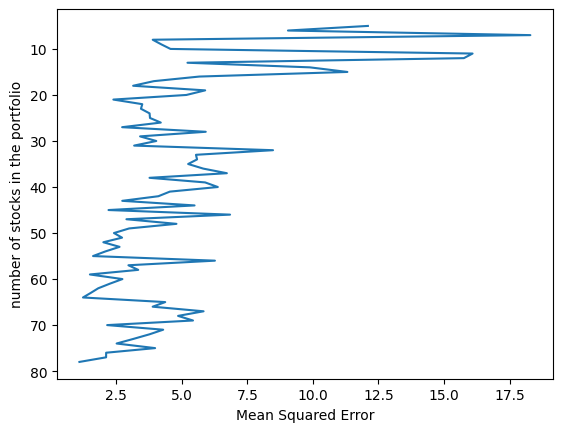

In [26]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 

# Part 2, Beat IBB Index

The second part of application in the paper is to select a subset of stocks from IBB Index to beat the Index.

In [0]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [0]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [0]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/beat_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/500
104/104 [==============================] - 1s 9ms/step - loss: 5.7999
Epoch 2/500
104/104 [==============================] - 0s 234us/step - loss: 5.6047
Epoch 3/500
104/104 [==============================] - 0s 237us/step - loss: 5.5153
Epoch 4/500
104/104 [==============================] - 0s 249us/step - loss: 5.4541
Epoch 5/500
104/104 [==============================] - 0s 268us/step - loss: 5.4033
Epoch 6/500
104/104 [==============================] - 0s 263us/step - loss: 5.3548
Epoch 7/500
104/104 [==============================] - 0s 238us/step - loss: 5.3053
Epoch 8/500
104/104 [==============================] - 0s 263us/step - loss: 5.2516
Epoch 9/500
104/104 [==============================] - 0s 234us/step - loss: 5.1890
Epoch 10/500
104/104 [==============================] - 0s 267us/step - loss: 5.1137
Epoch 11/500
104/104 [==============================] - 0s 256us/step - loss: 5.0237
Epoch 12/500
104/104 [==============================] - 0s 234us/step - loss

104/104 [==============================] - 0s 221us/step - loss: 2.6058
Epoch 98/500
104/104 [==============================] - 0s 249us/step - loss: 2.6005
Epoch 99/500
104/104 [==============================] - 0s 236us/step - loss: 2.5953
Epoch 100/500
104/104 [==============================] - 0s 277us/step - loss: 2.5901
Epoch 101/500
104/104 [==============================] - 0s 262us/step - loss: 2.5850
Epoch 102/500
104/104 [==============================] - 0s 283us/step - loss: 2.5799
Epoch 103/500
104/104 [==============================] - 0s 277us/step - loss: 2.5748
Epoch 104/500
104/104 [==============================] - 0s 270us/step - loss: 2.5698
Epoch 105/500
104/104 [==============================] - 0s 263us/step - loss: 2.5647
Epoch 106/500
104/104 [==============================] - 0s 234us/step - loss: 2.5598
Epoch 107/500
104/104 [==============================] - 0s 208us/step - loss: 2.5548
Epoch 108/500
104/104 [==============================] - 0s 268us/step

104/104 [==============================] - 0s 262us/step - loss: 2.3081
Epoch 192/500
104/104 [==============================] - 0s 256us/step - loss: 2.3068
Epoch 193/500
104/104 [==============================] - 0s 269us/step - loss: 2.3056
Epoch 194/500
104/104 [==============================] - 0s 266us/step - loss: 2.3043
Epoch 195/500
104/104 [==============================] - 0s 235us/step - loss: 2.3030
Epoch 196/500
104/104 [==============================] - 0s 246us/step - loss: 2.3018
Epoch 197/500
104/104 [==============================] - 0s 220us/step - loss: 2.3006
Epoch 198/500
104/104 [==============================] - 0s 234us/step - loss: 2.2994
Epoch 199/500
104/104 [==============================] - 0s 242us/step - loss: 2.2983
Epoch 200/500
104/104 [==============================] - 0s 240us/step - loss: 2.2971
Epoch 201/500
104/104 [==============================] - 0s 247us/step - loss: 2.2960
Epoch 202/500
104/104 [==============================] - 0s 282us/st

104/104 [==============================] - 0s 202us/step - loss: 2.2471
Epoch 287/500
104/104 [==============================] - 0s 305us/step - loss: 2.2468
Epoch 288/500
104/104 [==============================] - 0s 247us/step - loss: 2.2466
Epoch 289/500
104/104 [==============================] - 0s 207us/step - loss: 2.2463
Epoch 290/500
104/104 [==============================] - 0s 177us/step - loss: 2.2460
Epoch 291/500
104/104 [==============================] - 0s 213us/step - loss: 2.2457
Epoch 292/500
104/104 [==============================] - 0s 221us/step - loss: 2.2454
Epoch 293/500
104/104 [==============================] - 0s 754us/step - loss: 2.2452
Epoch 294/500
104/104 [==============================] - 0s 344us/step - loss: 2.2449
Epoch 295/500
104/104 [==============================] - 0s 325us/step - loss: 2.2446
Epoch 296/500
104/104 [==============================] - 0s 394us/step - loss: 2.2444
Epoch 297/500
104/104 [==============================] - 0s 509us/st

104/104 [==============================] - 0s 284us/step - loss: 2.2265
Epoch 381/500
104/104 [==============================] - 0s 288us/step - loss: 2.2264
Epoch 382/500
104/104 [==============================] - 0s 288us/step - loss: 2.2262
Epoch 383/500
104/104 [==============================] - 0s 274us/step - loss: 2.2261
Epoch 384/500
104/104 [==============================] - 0s 229us/step - loss: 2.2259
Epoch 385/500
104/104 [==============================] - 0s 265us/step - loss: 2.2257
Epoch 386/500
104/104 [==============================] - 0s 275us/step - loss: 2.2256
Epoch 387/500
104/104 [==============================] - 0s 270us/step - loss: 2.2254
Epoch 388/500
104/104 [==============================] - 0s 253us/step - loss: 2.2253
Epoch 389/500
104/104 [==============================] - 0s 209us/step - loss: 2.2251
Epoch 390/500
104/104 [==============================] - 0s 220us/step - loss: 2.2250
Epoch 391/500
104/104 [==============================] - 0s 296us/st

104/104 [==============================] - 0s 400us/step - loss: 2.2158
Epoch 475/500
104/104 [==============================] - 0s 281us/step - loss: 2.2157
Epoch 476/500
104/104 [==============================] - 0s 242us/step - loss: 2.2156
Epoch 477/500
104/104 [==============================] - 0s 216us/step - loss: 2.2155
Epoch 478/500
104/104 [==============================] - 0s 239us/step - loss: 2.2154
Epoch 479/500
104/104 [==============================] - 0s 225us/step - loss: 2.2153
Epoch 480/500
104/104 [==============================] - 0s 219us/step - loss: 2.2152
Epoch 481/500
104/104 [==============================] - 0s 186us/step - loss: 2.2151
Epoch 482/500
104/104 [==============================] - 0s 217us/step - loss: 2.2150
Epoch 483/500
104/104 [==============================] - 0s 216us/step - loss: 2.2149
Epoch 484/500
104/104 [==============================] - 0s 210us/step - loss: 2.2148
Epoch 485/500
104/104 [==============================] - 0s 693us/st

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [0]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.288070797920227 TLGT    US Equity
65 1.321529507637024 INO     US Equity
38 1.6224092245101929 LXRX    US Equity
76 1.8336045742034912 NVAX    US Equity
66 2.0743954181671143 CERS    US Equity
79 2.180755138397217 ZGNX    US Equity
81 2.4205305576324463 MNOV    US Equity
77 2.4227540493011475 PDLI    US Equity
71 2.5004076957702637 CRIS    US Equity
52 2.7980635166168213 IMMU    US Equity
17 2.858445644378662 EXEL    US Equity
75 3.101935386657715 GERN    US Equity
49 3.104473352432251 DEPO    US Equity
37 3.432741641998291 ARRY    US Equity
73 3.605278491973877 AVDL    US Equity
67 3.6483685970306396 PACB    US Equity
48 3.875211000442505 SGYP    US Equity
19 4.003232479095459 OPK     US Equity
42 4.117496967315674 RGEN    US Equity
55 4.188165187835693 BCRX    US Equity
31 4.208094596862793 HZNP    US Equity
72 4.267415523529053 PRTK    US Equity
82 4.347030162811279 ARWR    US Equity
80 4.5980401039123535 CGEN    US Equity
69 4.860776424407959 RIGL  

Let's have a look on how well this auto-encoder works on a certain stock.

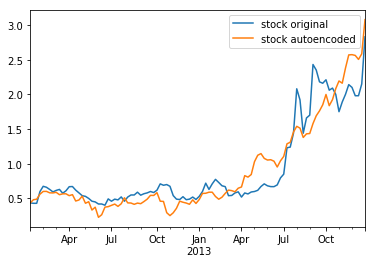

In [0]:
which_stock = 65

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

# Phase 2: Calibrating

For the application of beating the IBB index, we will amend the target data during the calibration phase by replacing all returns smaller than -5% by exactly 5%, which aims to create an index tracker with anti-correlation in periods of large drawdowns.

The comparison is shown as bellow.

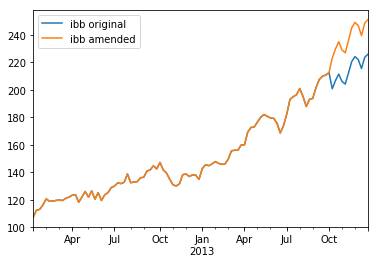

In [0]:
# from -5% to 5%
y_amended = ibb['calibrate']['percentage']
y_amended[y_amended < -5] = 5

# re-calculate the last price
y_amended[0] = 0
relative_percentage = (y_amended /100) + 1
lp_amended = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod()) 

# plot comparison
pd.Series(ibb['calibrate']['lp'].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb amended', legend=True)   

In [0]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.005))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.005))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = y_amended # amended percentage
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/beat_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - lp_amended)) # compare with amended last price

Epoch 1/500
104/104 [==============================] - 1s 13ms/step - loss: 9.1094
Epoch 2/500
104/104 [==============================] - 0s 160us/step - loss: 5.1081
Epoch 3/500
104/104 [==============================] - 0s 151us/step - loss: 3.7867
Epoch 4/500
104/104 [==============================] - 0s 172us/step - loss: 3.0469
Epoch 5/500
104/104 [==============================] - 0s 170us/step - loss: 2.5905
Epoch 6/500
104/104 [==============================] - 0s 294us/step - loss: 2.2992
Epoch 7/500
104/104 [==============================] - 0s 494us/step - loss: 2.0913
Epoch 8/500
104/104 [==============================] - 0s 259us/step - loss: 1.9365
Epoch 9/500
104/104 [==============================] - 0s 303us/step - loss: 1.7954
Epoch 10/500
104/104 [==============================] - 0s 324us/step - loss: 1.6589
Epoch 11/500
104/104 [==============================] - 0s 251us/step - loss: 1.5455
Epoch 12/500
104/104 [==============================] - 0s 251us/step - los

Epoch 97/500
104/104 [==============================] - 0s 210us/step - loss: 0.4265
Epoch 98/500
104/104 [==============================] - 0s 278us/step - loss: 0.4251
Epoch 99/500
104/104 [==============================] - 0s 422us/step - loss: 0.4189
Epoch 100/500
104/104 [==============================] - 0s 203us/step - loss: 0.4191
Epoch 101/500
104/104 [==============================] - 0s 188us/step - loss: 0.4172
Epoch 102/500
104/104 [==============================] - 0s 170us/step - loss: 0.4127
Epoch 103/500
104/104 [==============================] - 0s 276us/step - loss: 0.4120
Epoch 104/500
104/104 [==============================] - 0s 352us/step - loss: 0.4077
Epoch 105/500
104/104 [==============================] - 0s 398us/step - loss: 0.4060
Epoch 106/500
104/104 [==============================] - 0s 290us/step - loss: 0.4058
Epoch 107/500
104/104 [==============================] - 0s 525us/step - loss: 0.4001
Epoch 108/500
104/104 [==============================] - 

104/104 [==============================] - 0s 233us/step - loss: 0.2583
Epoch 193/500
104/104 [==============================] - 0s 183us/step - loss: 0.2596
Epoch 194/500
104/104 [==============================] - 0s 176us/step - loss: 0.2562
Epoch 195/500
104/104 [==============================] - 0s 168us/step - loss: 0.2575
Epoch 196/500
104/104 [==============================] - 0s 167us/step - loss: 0.2548
Epoch 197/500
104/104 [==============================] - 0s 160us/step - loss: 0.2559
Epoch 198/500
104/104 [==============================] - 0s 177us/step - loss: 0.2523
Epoch 199/500
104/104 [==============================] - 0s 171us/step - loss: 0.2548
Epoch 200/500
104/104 [==============================] - 0s 158us/step - loss: 0.2516
Epoch 201/500
104/104 [==============================] - 0s 159us/step - loss: 0.2518
Epoch 202/500
104/104 [==============================] - 0s 175us/step - loss: 0.2496
Epoch 203/500
104/104 [==============================] - 0s 183us/st

104/104 [==============================] - 0s 177us/step - loss: 0.2019
Epoch 288/500
104/104 [==============================] - 0s 222us/step - loss: 0.2006
Epoch 289/500
104/104 [==============================] - 0s 229us/step - loss: 0.2002
Epoch 290/500
104/104 [==============================] - 0s 271us/step - loss: 0.1995
Epoch 291/500
104/104 [==============================] - 0s 157us/step - loss: 0.2005
Epoch 292/500
104/104 [==============================] - 0s 162us/step - loss: 0.1998
Epoch 293/500
104/104 [==============================] - 0s 175us/step - loss: 0.1993
Epoch 294/500
104/104 [==============================] - 0s 176us/step - loss: 0.1983
Epoch 295/500
104/104 [==============================] - 0s 182us/step - loss: 0.1986
Epoch 296/500
104/104 [==============================] - 0s 160us/step - loss: 0.1975
Epoch 297/500
104/104 [==============================] - 0s 190us/step - loss: 0.1977
Epoch 298/500
104/104 [==============================] - 0s 178us/st

104/104 [==============================] - 0s 180us/step - loss: 0.1760
Epoch 383/500
104/104 [==============================] - 0s 201us/step - loss: 0.1755
Epoch 384/500
104/104 [==============================] - 0s 183us/step - loss: 0.1753
Epoch 385/500
104/104 [==============================] - 0s 214us/step - loss: 0.1745
Epoch 386/500
104/104 [==============================] - 0s 244us/step - loss: 0.1747
Epoch 387/500
104/104 [==============================] - 0s 220us/step - loss: 0.1748
Epoch 388/500
104/104 [==============================] - 0s 205us/step - loss: 0.1739
Epoch 389/500
104/104 [==============================] - 0s 276us/step - loss: 0.1738
Epoch 390/500
104/104 [==============================] - 0s 250us/step - loss: 0.1742
Epoch 391/500
104/104 [==============================] - 0s 171us/step - loss: 0.1739
Epoch 392/500
104/104 [==============================] - 0s 170us/step - loss: 0.1731
Epoch 393/500
104/104 [==============================] - 0s 161us/st

104/104 [==============================] - 0s 232us/step - loss: 0.1567
Epoch 477/500
104/104 [==============================] - 0s 232us/step - loss: 0.1568
Epoch 478/500
104/104 [==============================] - 0s 204us/step - loss: 0.1566
Epoch 479/500
104/104 [==============================] - 0s 305us/step - loss: 0.1564
Epoch 480/500
104/104 [==============================] - 0s 208us/step - loss: 0.1563
Epoch 481/500
104/104 [==============================] - 0s 213us/step - loss: 0.1560
Epoch 482/500
104/104 [==============================] - 0s 188us/step - loss: 0.1561
Epoch 483/500
104/104 [==============================] - 0s 182us/step - loss: 0.1560
Epoch 484/500
104/104 [==============================] - 0s 174us/step - loss: 0.1555
Epoch 485/500
104/104 [==============================] - 0s 198us/step - loss: 0.1556
Epoch 486/500
104/104 [==============================] - 0s 186us/step - loss: 0.1557
Epoch 487/500
104/104 [==============================] - 0s 199us/st

104/104 [==============================] - 0s 247us/step - loss: 0.3330
Epoch 73/500
104/104 [==============================] - 0s 226us/step - loss: 0.3319
Epoch 74/500
104/104 [==============================] - 0s 194us/step - loss: 0.3324
Epoch 75/500
104/104 [==============================] - 0s 188us/step - loss: 0.3299
Epoch 76/500
104/104 [==============================] - 0s 169us/step - loss: 0.3283
Epoch 77/500
104/104 [==============================] - 0s 170us/step - loss: 0.3260
Epoch 78/500
104/104 [==============================] - 0s 191us/step - loss: 0.3236
Epoch 79/500
104/104 [==============================] - 0s 171us/step - loss: 0.3218
Epoch 80/500
104/104 [==============================] - 0s 167us/step - loss: 0.3198
Epoch 81/500
104/104 [==============================] - 0s 206us/step - loss: 0.3193
Epoch 82/500
104/104 [==============================] - 0s 172us/step - loss: 0.3216
Epoch 83/500
104/104 [==============================] - 0s 165us/step - loss: 

104/104 [==============================] - 0s 287us/step - loss: 0.2500
Epoch 168/500
104/104 [==============================] - 0s 195us/step - loss: 0.2494
Epoch 169/500
104/104 [==============================] - 0s 191us/step - loss: 0.2488
Epoch 170/500
104/104 [==============================] - 0s 163us/step - loss: 0.2483
Epoch 171/500
104/104 [==============================] - 0s 161us/step - loss: 0.2492
Epoch 172/500
104/104 [==============================] - 0s 191us/step - loss: 0.2515
Epoch 173/500
104/104 [==============================] - 0s 188us/step - loss: 0.2523
Epoch 174/500
104/104 [==============================] - 0s 164us/step - loss: 0.2492
Epoch 175/500
104/104 [==============================] - 0s 167us/step - loss: 0.2480
Epoch 176/500
104/104 [==============================] - 0s 180us/step - loss: 0.2472
Epoch 177/500
104/104 [==============================] - 0s 178us/step - loss: 0.2467
Epoch 178/500
104/104 [==============================] - ETA: 0s - l

104/104 [==============================] - 0s 182us/step - loss: 0.2267
Epoch 262/500
104/104 [==============================] - 0s 188us/step - loss: 0.2263
Epoch 263/500
104/104 [==============================] - 0s 180us/step - loss: 0.2261
Epoch 264/500
104/104 [==============================] - 0s 165us/step - loss: 0.2258
Epoch 265/500
104/104 [==============================] - 0s 161us/step - loss: 0.2255
Epoch 266/500
104/104 [==============================] - 0s 185us/step - loss: 0.2252
Epoch 267/500
104/104 [==============================] - 0s 179us/step - loss: 0.2250
Epoch 268/500
104/104 [==============================] - 0s 156us/step - loss: 0.2247
Epoch 269/500
104/104 [==============================] - 0s 158us/step - loss: 0.2245
Epoch 270/500
104/104 [==============================] - 0s 206us/step - loss: 0.2256
Epoch 271/500
104/104 [==============================] - 0s 177us/step - loss: 0.2308
Epoch 272/500
104/104 [==============================] - 0s 181us/st

104/104 [==============================] - 0s 188us/step - loss: 0.2176
Epoch 357/500
104/104 [==============================] - 0s 184us/step - loss: 0.2198
Epoch 358/500
104/104 [==============================] - 0s 178us/step - loss: 0.2207
Epoch 359/500
104/104 [==============================] - 0s 172us/step - loss: 0.2181
Epoch 360/500
104/104 [==============================] - 0s 176us/step - loss: 0.2172
Epoch 361/500
104/104 [==============================] - 0s 171us/step - loss: 0.2168
Epoch 362/500
104/104 [==============================] - 0s 182us/step - loss: 0.2165
Epoch 363/500
104/104 [==============================] - 0s 162us/step - loss: 0.2163
Epoch 364/500
104/104 [==============================] - 0s 184us/step - loss: 0.2160
Epoch 365/500
104/104 [==============================] - 0s 166us/step - loss: 0.2158
Epoch 366/500
104/104 [==============================] - 0s 159us/step - loss: 0.2156
Epoch 367/500
104/104 [==============================] - 0s 175us/st

104/104 [==============================] - 0s 185us/step - loss: 0.2108
Epoch 452/500
104/104 [==============================] - 0s 184us/step - loss: 0.2106
Epoch 453/500
104/104 [==============================] - 0s 188us/step - loss: 0.2104
Epoch 454/500
104/104 [==============================] - 0s 158us/step - loss: 0.2103
Epoch 455/500
104/104 [==============================] - 0s 165us/step - loss: 0.2101
Epoch 456/500
104/104 [==============================] - ETA: 0s - loss: 0.062 - 0s 176us/step - loss: 0.2100
Epoch 457/500
104/104 [==============================] - 0s 188us/step - loss: 0.2099
Epoch 458/500
104/104 [==============================] - 0s 174us/step - loss: 0.2097
Epoch 459/500
104/104 [==============================] - 0s 173us/step - loss: 0.2096
Epoch 460/500
104/104 [==============================] - 0s 166us/step - loss: 0.2095
Epoch 461/500
104/104 [==============================] - 0s 165us/step - loss: 0.2094
Epoch 462/500
104/104 [=====================

104/104 [==============================] - 0s 339us/step - loss: 0.2831
Epoch 47/500
104/104 [==============================] - 0s 218us/step - loss: 0.2729
Epoch 48/500
104/104 [==============================] - 0s 224us/step - loss: 0.2653
Epoch 49/500
104/104 [==============================] - 0s 179us/step - loss: 0.2614
Epoch 50/500
104/104 [==============================] - 0s 173us/step - loss: 0.2604
Epoch 51/500
104/104 [==============================] - 0s 219us/step - loss: 0.2507
Epoch 52/500
104/104 [==============================] - 0s 219us/step - loss: 0.2430
Epoch 53/500
104/104 [==============================] - 0s 193us/step - loss: 0.2376
Epoch 54/500
104/104 [==============================] - 0s 209us/step - loss: 0.2375
Epoch 55/500
104/104 [==============================] - 0s 218us/step - loss: 0.2282
Epoch 56/500
104/104 [==============================] - 0s 447us/step - loss: 0.2208
Epoch 57/500
104/104 [==============================] - 0s 365us/step - loss: 

104/104 [==============================] - 0s 296us/step - loss: 0.0894
Epoch 141/500
104/104 [==============================] - 0s 216us/step - loss: 0.0888
Epoch 142/500
104/104 [==============================] - 0s 230us/step - loss: 0.0887
Epoch 143/500
104/104 [==============================] - 0s 208us/step - loss: 0.0881
Epoch 144/500
104/104 [==============================] - 0s 222us/step - loss: 0.0879
Epoch 145/500
104/104 [==============================] - 0s 189us/step - loss: 0.0876
Epoch 146/500
104/104 [==============================] - 0s 239us/step - loss: 0.0873
Epoch 147/500
104/104 [==============================] - 0s 209us/step - loss: 0.0870
Epoch 148/500
104/104 [==============================] - 0s 180us/step - loss: 0.0866
Epoch 149/500
104/104 [==============================] - 0s 165us/step - loss: 0.0864
Epoch 150/500
104/104 [==============================] - 0s 211us/step - loss: 0.0860
Epoch 151/500
104/104 [==============================] - 0s 201us/st

104/104 [==============================] - 0s 214us/step - loss: 0.0750
Epoch 235/500
104/104 [==============================] - 0s 188us/step - loss: 0.0749
Epoch 236/500
104/104 [==============================] - 0s 213us/step - loss: 0.0749
Epoch 237/500
104/104 [==============================] - 0s 154us/step - loss: 0.0748
Epoch 238/500
104/104 [==============================] - 0s 202us/step - loss: 0.0747
Epoch 239/500
104/104 [==============================] - 0s 171us/step - loss: 0.0746
Epoch 240/500
104/104 [==============================] - 0s 222us/step - loss: 0.0746
Epoch 241/500
104/104 [==============================] - 0s 208us/step - loss: 0.0745
Epoch 242/500
104/104 [==============================] - 0s 230us/step - loss: 0.0745
Epoch 243/500
104/104 [==============================] - 0s 198us/step - loss: 0.0744
Epoch 244/500
104/104 [==============================] - 0s 171us/step - loss: 0.0744
Epoch 245/500
104/104 [==============================] - 0s 170us/st

104/104 [==============================] - 0s 198us/step - loss: 0.0702
Epoch 329/500
104/104 [==============================] - 0s 244us/step - loss: 0.0702
Epoch 330/500
104/104 [==============================] - 0s 219us/step - loss: 0.0701
Epoch 331/500
104/104 [==============================] - 0s 195us/step - loss: 0.0701
Epoch 332/500
104/104 [==============================] - 0s 192us/step - loss: 0.0700
Epoch 333/500
104/104 [==============================] - ETA: 0s - loss: 0.091 - 0s 182us/step - loss: 0.0700
Epoch 334/500
104/104 [==============================] - 0s 184us/step - loss: 0.0699
Epoch 335/500
104/104 [==============================] - 0s 175us/step - loss: 0.0699
Epoch 336/500
104/104 [==============================] - 0s 177us/step - loss: 0.0699
Epoch 337/500
104/104 [==============================] - 0s 165us/step - loss: 0.0698
Epoch 338/500
104/104 [==============================] - 0s 198us/step - loss: 0.0698
Epoch 339/500
104/104 [=====================

104/104 [==============================] - 0s 253us/step - loss: 0.0667
Epoch 423/500
104/104 [==============================] - 0s 235us/step - loss: 0.0666
Epoch 424/500
104/104 [==============================] - 0s 199us/step - loss: 0.0666
Epoch 425/500
104/104 [==============================] - 0s 177us/step - loss: 0.0666
Epoch 426/500
104/104 [==============================] - 0s 177us/step - loss: 0.0666
Epoch 427/500
104/104 [==============================] - 0s 170us/step - loss: 0.0665
Epoch 428/500
104/104 [==============================] - 0s 171us/step - loss: 0.0665
Epoch 429/500
104/104 [==============================] - 0s 175us/step - loss: 0.0665
Epoch 430/500
104/104 [==============================] - 0s 231us/step - loss: 0.0664
Epoch 431/500
104/104 [==============================] - 0s 219us/step - loss: 0.0664
Epoch 432/500
104/104 [==============================] - 0s 176us/step - loss: 0.0664
Epoch 433/500
104/104 [==============================] - 0s 206us/st

Now we would like to see how similar these 3 portfolios perfom as the modified(amended) IBB Index does on training dates.

S25 2-norm difference:  10.0282
S45 2-norm difference:  35.3057
S65 2-norm difference:  14.6669


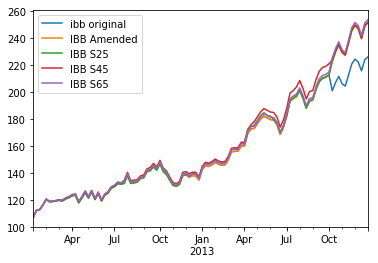

In [0]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB Amended', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    


# Phase 3: Validating

In [0]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/beat_s' + str(s) + '.h5')
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
#     total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

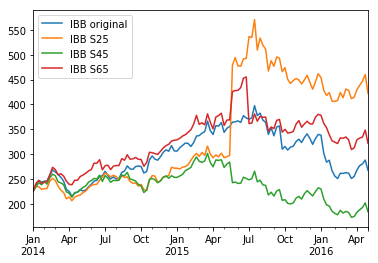

In [0]:
# plot original IBB last price
pd.Series(ibb['validate']['lp'].to_numpy(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

# 2-norm difference is now meaningless to compare
for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)